In [ ]:
pip install matplotlib --upgrade

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Covid radiography/CovidR.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Completed")

Completed


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras as tf

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

In [ ]:
c = '/content/COVID-19_Radiography_Dataset/COVID/images'
n = '/content/COVID-19_Radiography_Dataset/Normal/images'
p = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [ ]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 2500) + os.listdir(p)

In [ ]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

In [ ]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,/content/COVID-19_Radiography_Dataset/COVID/im...,2
1,/content/COVID-19_Radiography_Dataset/COVID/im...,2
2,/content/COVID-19_Radiography_Dataset/COVID/im...,2
3,/content/COVID-19_Radiography_Dataset/COVID/im...,2
4,/content/COVID-19_Radiography_Dataset/COVID/im...,2


In [ ]:
df.shape

(7461, 2)

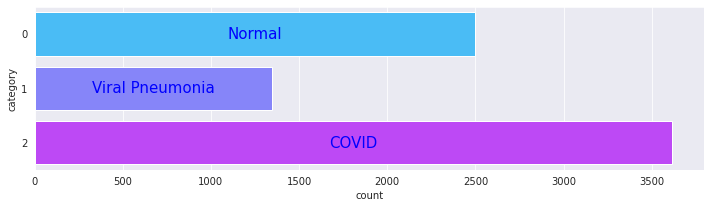

In [ ]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0],
              labels=['Normal', 'Viral Pneumonia', 'COVID'],
              label_type='center', size=15, color='b')
plt.show()

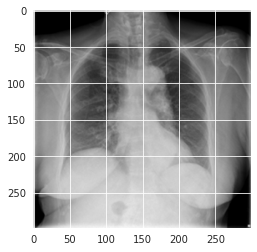

In [ ]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

In [ ]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [ ]:
print(train_data)

                                               filename category
0     /content/COVID-19_Radiography_Dataset/COVID/im...        2
1     /content/COVID-19_Radiography_Dataset/COVID/im...        2
2     /content/COVID-19_Radiography_Dataset/Normal/i...        0
3     /content/COVID-19_Radiography_Dataset/Normal/i...        0
4     /content/COVID-19_Radiography_Dataset/Viral Pn...        1
...                                                 ...      ...
5963  /content/COVID-19_Radiography_Dataset/Normal/i...        0
5964  /content/COVID-19_Radiography_Dataset/COVID/im...        2
5965  /content/COVID-19_Radiography_Dataset/COVID/im...        2
5966  /content/COVID-19_Radiography_Dataset/COVID/im...        2
5967  /content/COVID-19_Radiography_Dataset/Normal/i...        0

[5968 rows x 2 columns]


In [ ]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [ ]:
print(test_data)

                                              filename category
0    /content/COVID-19_Radiography_Dataset/COVID/im...        2
1    /content/COVID-19_Radiography_Dataset/Viral Pn...        1
2    /content/COVID-19_Radiography_Dataset/COVID/im...        2
3    /content/COVID-19_Radiography_Dataset/COVID/im...        2
4    /content/COVID-19_Radiography_Dataset/COVID/im...        2
..                                                 ...      ...
741  /content/COVID-19_Radiography_Dataset/COVID/im...        2
742  /content/COVID-19_Radiography_Dataset/COVID/im...        2
743  /content/COVID-19_Radiography_Dataset/COVID/im...        2
744  /content/COVID-19_Radiography_Dataset/COVID/im...        2
745  /content/COVID-19_Radiography_Dataset/Normal/i...        0

[746 rows x 2 columns]


In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 5968 validated image filenames belonging to 3 classes.


In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 747 validated image filenames belonging to 3 classes.


In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape = (224,224,3),
                                                     include_top=False)
for layer in base_model.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='Softmax')
])

callbacks = [

    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]



from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)


model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

NameError: name 'tf' is not defined

In [ ]:
model.dataflow()

AttributeError: ignored

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator, epochs=12,
                    callbacks=[callbacks])

Epoch 1/12
187/187 [==============================] - 974s 5s/step - loss: 0.4594 - accuracy: 0.8157 - val_loss: 0.3046 - val_accuracy: 0.8809 - lr: 0.0010
Epoch 2/12
187/187 [==============================] - 1007s 5s/step - loss: 0.3387 - accuracy: 0.8639 - val_loss: 0.2592 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 3/12
187/187 [==============================] - 994s 5s/step - loss: 0.3033 - accuracy: 0.8752 - val_loss: 0.2586 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 4/12
187/187 [==============================] - 979s 5s/step - loss: 0.2955 - accuracy: 0.8805 - val_loss: 0.2487 - val_accuracy: 0.9157 - lr: 0.0010
Epoch 5/12
187/187 [==============================] - 984s 5s/step - loss: 0.2846 - accuracy: 0.8797 - val_loss: 0.2755 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 6/12
187/187 [==============================] - 983s 5s/step - loss: 0.2602 - accuracy: 0.8928 - val_loss: 0.2358 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 7/12
187/187 [==============================] - 975s 5s/s

In [ ]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 746 validated image filenames belonging to 3 classes.


In [ ]:

ytest=model.evaluate(test_set)

24/24 [==============================] - 101s 4s/step - loss: 0.2435 - accuracy: 0.9035


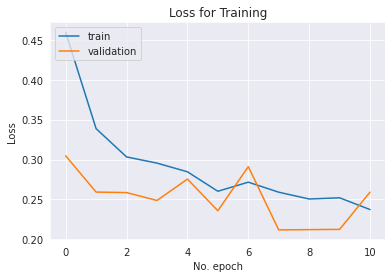

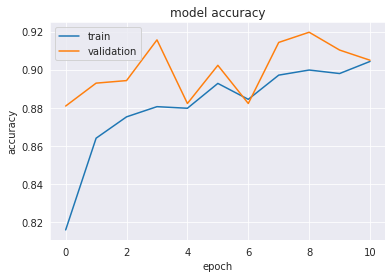

In [ ]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(valid_generator)


24/24 [==============================] - 115s 5s/step


In [ ]:
print(prob)

[[0.00599769 0.00630778 0.98769444]
 [0.04569564 0.9513788  0.00292552]
 [0.16602133 0.02078376 0.81319493]
 ...
 [0.13948625 0.02700369 0.8335099 ]
 [0.91089064 0.00171177 0.08739761]
 [0.90056914 0.00353593 0.09589498]]


In [ ]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1)


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Normal','Viral Pneumonia', 'COVID'], digits=5))

24/24 [==============================] - 108s 4s/step


                 precision    recall  f1-score   support

         Normal    0.80537   0.96000   0.87591       250
Viral Pneumonia    0.98347   0.88806   0.93333       134
          COVID    0.96330   0.87017   0.91437       362

       accuracy                        0.90349       746
      macro avg    0.91738   0.90608   0.90787       746
   weighted avg    0.91400   0.90349   0.90489       746



In [ ]:
model.save('vgg16.h5')

In [ ]:
history.history['val_accuracy']


[0.8848728537559509,
 0.8862115144729614,
 0.9009370803833008,
 0.9210174083709717]

True value is : COVID
Prediction is:
COVID 


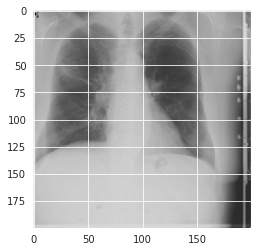

In [ ]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[-1].split('-')[0].upper()
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'VIRAL PNEUMONIA':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')

image = load_img(sample, target_size=(200, 200))
img = img_to_array(image)/255
img = img.reshape((1, 200, 200, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID ")

plt.imshow(image)

In [ ]:
#VGG16

In [ ]:
base_model1 = tf.keras.applications.VGG16(weights='imagenet', input_shape = (224,224,3),
                                                     include_top=False)
for layer in base_model1.layers:
    layer.trainable = False

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model1 = tf.keras.Sequential([
    base_model1,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='Softmax')
])

callbacks = [

    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]



from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)


model1.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_generator,
                    validation_data=valid_generator, epochs=1,
                    callbacks=[callbacks])

187/187 [==============================] - 1057s 6s/step - loss: 0.4589 - accuracy: 0.8175 - val_loss: 0.3703 - val_accuracy: 0.8353 - lr: 0.0010


In [ ]:
#VGG19

In [ ]:
base_model2 = tf.keras.applications.VGG19(weights='imagenet', input_shape = (224,224,3),
                                                     include_top=False)
for layer in base_model2.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
model2 = tf.keras.Sequential([
    base_model2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='Softmax')
])

callbacks = [

    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]



from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)


model2.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_generator,
                    validation_data=valid_generator, epochs=12,
                    callbacks=[callbacks])

Epoch 1/12
187/187 [==============================] - 4228s 23s/step - loss: 0.5693 - accuracy: 0.7704 - val_loss: 0.7164 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 2/12
187/187 [==============================] - 4178s 22s/step - loss: 0.4456 - accuracy: 0.8143 - val_loss: 0.4919 - val_accuracy: 0.8126 - lr: 0.0010
Epoch 3/12
187/187 [==============================] - 4155s 22s/step - loss: 0.4092 - accuracy: 0.8304 - val_loss: 1.3276 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 4/12
187/187 [==============================] - 4010s 21s/step - loss: 0.4108 - accuracy: 0.8329 - val_loss: 0.3515 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 5/12
162/187 [========================>.....] - ETA: 8:14 - loss: 0.4051 - accuracy: 0.8355

In [ ]:
#Xception

In [ ]:
import tensorflow as tf
base_model3 = tf.keras.applications.Xception(weights='imagenet', input_shape = (224,224,3),
                                                     include_top=False)
for layer in base_model3.layers:
    layer.trainable = False

In [ ]:
model3 = tf.keras.Sequential([
    base_model3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='Softmax')
])

callbacks = [

    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]



from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)


model3.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_generator,
                    validation_data=valid_generator, epochs=1,
                    callbacks=[callbacks])

187/187 [==============================] - 1254s 7s/step - loss: 0.4895 - accuracy: 0.8048 - val_loss: 0.5535 - val_accuracy: 0.7523 - lr: 0.0010


In [ ]:
#ensemble

In [ ]:
model1.save('saved_models/model1.hdf5')
model2.save('saved_models/model2.hdf5')
model3.save('saved_models/model3.hdf5')

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_models/model1.hdf5')
model2 = load_model('saved_models/model2.hdf5')
model3 = load_model('saved_models/model3.hdf5')

models = [model1, model2, model3]

preds = [model.predict(X_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict_classes(train_generator)
prediction2 = model2.predict_classes(X_test)
prediction3 = model3.predict_classes(X_test)

accuracy1 = accuracy_score(y_test, prediction1)
accuracy2 = accuracy_score(y_test, prediction2)
accuracy3 = accuracy_score(y_test, prediction3)
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

In [ ]:
#weighted avg

In [ ]:
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(X_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(y_test, weighted_ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(X_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(y_test, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)

max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w2=", max_acc_row[2], " and w3=", max_acc_row[3])


In [ ]:
### Explore metrics for the ideal weighted ensemble model.

models = [model1, model2, model3]
preds = [model.predict(X_test) for model in models]
preds=np.array(preds)
ideal_weights = [0.4, 0.1, 0.2]

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(y_test, ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(X_test[i,:,:,0])
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[int(y_test[i])])

from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(y_test, ideal_weighted_ensemble_prediction)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
fig, ax = plt.subplots(figsize=(12,12))
plt.bar(np.arange(24), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(24), class_names)

In [ ]:
########vggscratch

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 5968 validated image filenames belonging to 3 classes.


In [ ]:
test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_dataframe(
    test_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 1493 validated image filenames belonging to 3 classes.


In [ ]:
#from scartch of vgg16

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=8192,activation="relu"))
model.add(Dense(units=8192,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=100,generator=train_generator, validation_data= test_generator, validation_steps=1,epochs=100,callbacks=[checkpoint,early])

In [ ]:
)

In [ ]:
#essential parameters

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=3,
    epochs = 50, )

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)